What if you wanted a directed graph of an ancestor-descendant type of situation? Below is an example using the `Digraph` in the `graphviz` packages (https://pypi.org/project/graphviz/).  Also, what if you wanted to obtain the total number of descendants of each possible ancestor?


In [1]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from subprocess import check_call 


In [2]:
def plot_graph(df, child_col, parent_col, figsize='5',
               title='Descendants graph'):
    """Get the graph corresponding to the ancestor and its descendant.

    parameters
    ----------
    df: pandas.DataFrame
    child_col: str
    parent_col: str
    figsize: str, of the form, str(int)

    Returns
    -------
    dot: dote object
    """
    dd = df[[child_col, parent_col]].values.flatten()
    nodes = [str(x) for x in np.unique(dd)]
    values = [str(y) for y in range(len(nodes))]
    dictionary = dict(zip(nodes, values))
    dictionary
    dot = Digraph(comment=title)
    dot.attr(ratio="compress", size=figsize, rankdir='LR')
    dot.node_attr.update(color='lightblue2', style='filled')

    for key, value in dictionary.items():
        dot.node(value, key)

    for i in range(len(df)):
        child = str(df[child_col][i])
        parent = str(df[parent_col][i])
        dot.edge(dictionary[parent], dictionary[child])
    return dot


def get_ancestor_descendant_df(df, child_col, parent_col):
    """Given a child-parent table, obtain the ancestor_descendant table.

    parameters
    ----------
    df: pandas.DataFrame
    parent_col: str
    child_col: str

    Returns
    -------
    new_df: pandas.DataFrame
    """
    def get_child_list(df, parent_value):
        list_of_children = []
        list_of_children.append(df[df[parent_col] == parent_value][child_col].values)

        for i, rowi in df[df[parent_col] == parent_value].iterrows():
            if rowi[child_col] != parent_value:
                list_of_children.append(get_child_list(df, rowi[child_col]))
        # flatten the list
        list_of_children = [item for sublist in
                            list_of_children for item in sublist]
        return list_of_children

    new_df = pd.DataFrame(columns=['ancestor', 'descendant'])
    for j, rowj in df.iterrows():
        temp_df = pd.DataFrame(columns=['ancestor', 'descendant'])

        temp_df['descendant'] = pd.Series(get_child_list(df, rowj[parent_col]))
        temp_df['ancestor'] = rowj[parent_col]

        new_df = new_df.append(temp_df)
        new_df = new_df.drop_duplicates().reset_index(drop=True)

    return new_df


In [3]:
# Create a child/parent (sub_category/category) dataframe
# How about apparel 

child_category = ['Jeans',
                  'Leggings',
                  'Bootcut',
                  'Sweatpants',
                  'Knee-High Skirt',
                  'Skinny Jeans',
                  'Low Rise',
                  'High Rise',
                  'Capris',
                  'Pencil Skirt',
                  'Short Skirt',
                  'Long Skirt']

parent_category = ['Pants',
                  'Pants',
                  'Jeans',
                  'Pants',
                  'Skirts',
                  'Jeans',
                  'Jeans',
                  'Jeans',
                  'Pants',
                  'Skirts',
                  'Skirts',
                  'Skirts']

df = pd.DataFrame({'child_category': child_category,
                   'parent_category': parent_category})
df

,child_category,parent_category
0,Jeans,Pants
1,Leggings,Pants
2,Bootcut,Jeans
3,Sweatpants,Pants
4,Knee-High Skirt,Skirts
5,Skinny Jeans,Jeans
6,Low Rise,Jeans
7,High Rise,Jeans
8,Capris,Pants
9,Pencil Skirt,Skirts


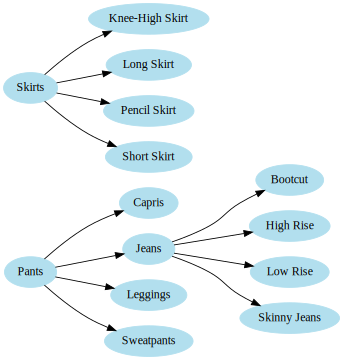

In [4]:
plot_graph(df, 'child_category', 'parent_category')

In [5]:
# to save a jpg file 
dot = plot_graph(df, 'child_category', 'parent_category')
dot.render(filename='tree.dot')
check_call(['dot', '-Tjpg', 'tree.dot', '-o', 'tree.jpg'])

0

In [6]:
# optain the ancestor-descendant DataFrame
ad_df = get_ancestor_descendant_df(df, 'child_category', 'parent_category')
ad_df

,ancestor,descendant
0,Pants,Jeans
1,Pants,Leggings
2,Pants,Sweatpants
3,Pants,Capris
4,Pants,Bootcut
5,Pants,Skinny Jeans
6,Pants,Low Rise
7,Pants,High Rise
8,Jeans,Bootcut
9,Jeans,Skinny Jeans


In [7]:
# get the number of descendants for each ancestor
ad_df.groupby('ancestor').count()

,descendant
ancestor,
Jeans,4
Pants,8
Skirts,4
